# Train an image classification model

In [1]:
import os
import time
import datetime
import requests
import tarfile
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
print(tf.__version__)

2.3.1


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
batch_size = 32
num_epochs = 50

In [5]:
dataDir = 'data/kaggle_pets/raw'

resultsDir = 'results'
modelsDir = 'models/kaggle_xception'
logsDir = 'logs/kaggle_xception'

In [6]:
if not os.path.exists(dataDir):
    os.makedirs(dataDir)

if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

if not os.path.exists(modelsDir):
    os.makedirs(modelsDir)
        
if not os.path.exists(logsDir):
    os.makedirs(logsDir)

## Download data

We download data from a S3 bucket and uncompress

In [7]:
dataURL = 'https://rmunoz-public.s3.amazonaws.com/cv/kaggle_pets.tgz'
dataFile = 'data/kaggle_pets.tgz'

r = requests.get(dataURL, allow_redirects=True)

open(dataFile, 'wb').write(r.content)

717782003

In [8]:
tar = tarfile.open(dataFile, "r:gz")
tar.extractall('data')
tar.close()

## Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [9]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(dataDir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        fobj = open(fpath, "rb")
        if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
            num_skipped += 1
            # Delete corrupted image
            os.system("rm " + fpath)
            
print("Deleted %d images" % num_skipped)

Deleted 0 images


## Generate dataset

In [10]:
image_size = (64, 64)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataDir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog" and label 0 is "cat".


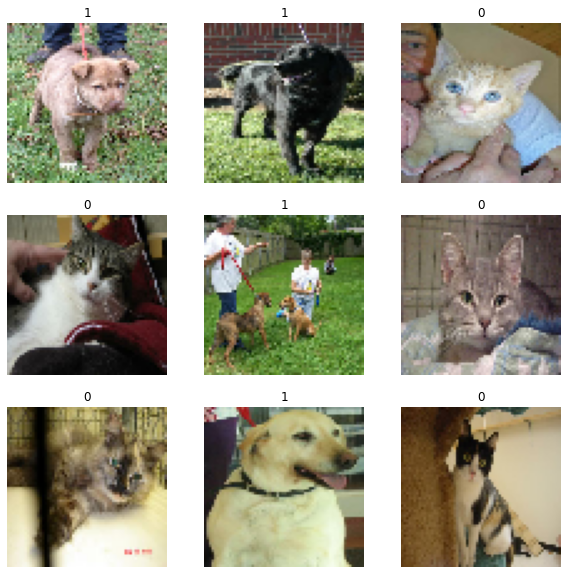

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying data_augmentation repeatedly to the first image in the dataset:

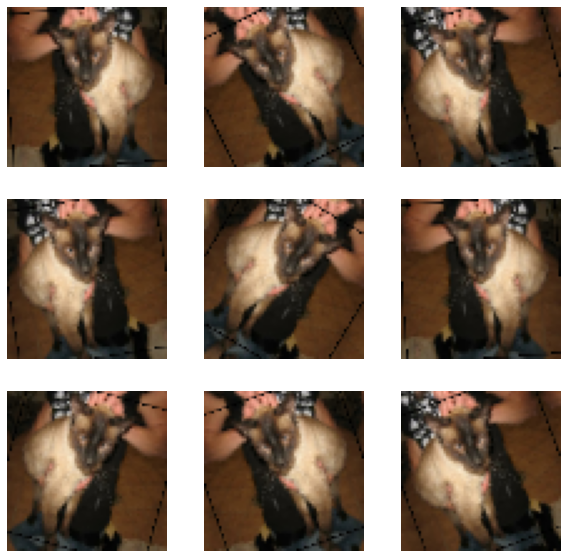

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

In [15]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [19]:
modelDiagramFile = os.path.join(resultsDir, 'model_Xception.png')

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, to_file=modelDiagramFile, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


## Train the model

In [ ]:
logsCheckDir = os.path.join(logsDir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
callbacks = [
    keras.callbacks.ModelCheckpoint(os.path.join(modelsDir, "model_checkpoint_{epoch}.h5")),
    keras.callbacks.TensorBoard(log_dir=logsCheckDir, histogram_freq=1),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

startTime = time.time()

modelHistory = model.fit(
    train_ds, epochs=num_epochs, callbacks=callbacks, validation_data=val_ds,
)

endTime = time.time()

elapsedTime = (endTime - startTime)/60.
print("\nTotal time for model training: {} minutes".format(elapsedTime))

Epoch 1/50
174/586 [=======>......................] - ETA: 2:17 - loss: 0.6735 - accuracy: 0.6272

In [ ]:
modelFile = os.path.join(modelsDir, 'model_best.h5')

model.save(modelFile)

## Evaluate model

In [ ]:
import numpy as np
import requests

In [ ]:
model = keras.models.load_model(modelFile)

In [ ]:
def predict_url(url):
    response = requests.get(url, stream=True)
    image = tf.image.decode_jpeg(response.content)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, image_size)
    image = tf.expand_dims(image, 0)
    
    y_prob = model.predict(image)
    print(y_prob)
    y_classes = y_prob.argmax(axis=-1)
    
    if y_classes == 0:
        print("Predicción del modelo: Gato")
    elif y_classes == 1:
        print("Predicción del modelo: Perro")

In [ ]:
url="https://misanimales.com/wp-content/uploads/2014/12/gato-enfermo.jpg"
predict_url(url)

In [ ]:
url="https://s3-eu-west-1.amazonaws.com/barkibu-blog/blog+images/mi-perro-tiene-hipo-muy-seguido-que-le-pasa/perro-hipo-1.jpg"
predict_url(url)